In [132]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

import numpy as np
from numpy import hstack as stack
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import acf

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### ARMA modelling with `interestrate.csv`. Keep the last year for forecasting.

178: 177 + 1


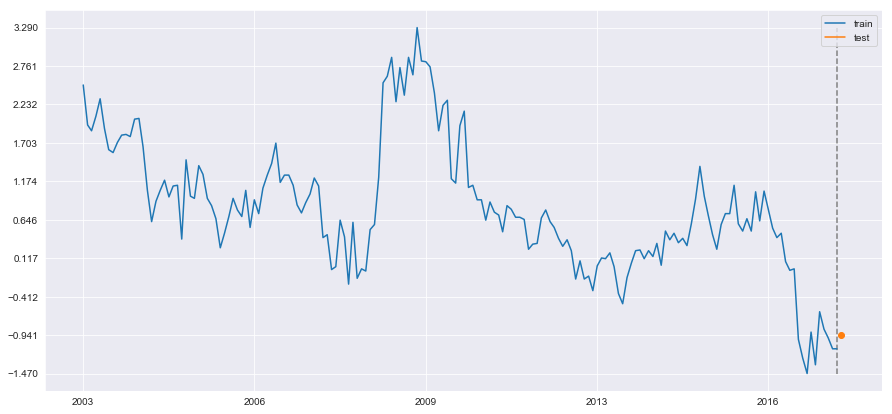

In [178]:
# Real (inﬂation corrected) interest rate for bank deposits with
# investment durations between one and two years
interestrate = pd.read_csv('data/interestrate.csv', sep=';',
                           index_col=0, header=None).iloc[:,0]
interestrate = interestrate.map(lambda s: float(s.replace(',', '.')))
interestrate.index = interestrate.index.astype('datetime64[ns]')

mpl.rcParams['figure.figsize'] = (15,7)

N = len(interestrate)
n_train = N-1
train, test, n_test = split_ts(interestrate, n_train)

##### (a) Check the ACF and decide about the strength of the memory in the time series using Box-Ljung/Pierce tests.

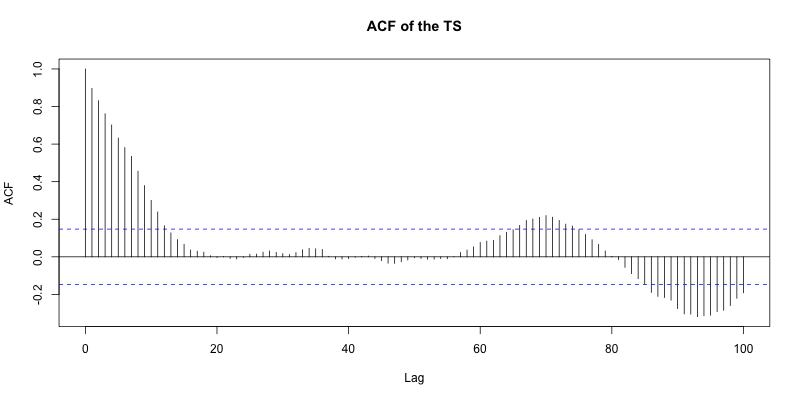

In [198]:
%%R -i train -i test -w 800 -h 400 -u px
train <- as.numeric(train)
m <- 100
AutoCorrelation <- acf(train, lag.max=m, plot = FALSE)
plot(AutoCorrelation, main = 'ACF of the TS')

In [180]:
%%R
m <- 20
print(Box.test(train, lag=m, type="Ljung-Box"))
print(Box.test(train, lag=m, type="Box-Pierce"))
alpha <- 0.05
cat('Chi-squared with', m,'df at alpha', alpha, ':', pchisq(1-alpha, m))


	Box-Ljung test

data:  train
X-squared = 760.51, df = 20, p-value < 2.2e-16


	Box-Pierce test

data:  train
X-squared = 734.22, df = 20, p-value < 2.2e-16

Chi-squared with 20 df at alpha 0.05 : 1.047083e-10

> So the H0 (the process is not autocorrelated) can be rejected. There exists some memory in the time series.

(b) Try `MA(1)`, `AR(1)` and `ARMA(1,1)` processes and check the ﬁt (ACF of residuals, AIC, etc.)


MA(1):


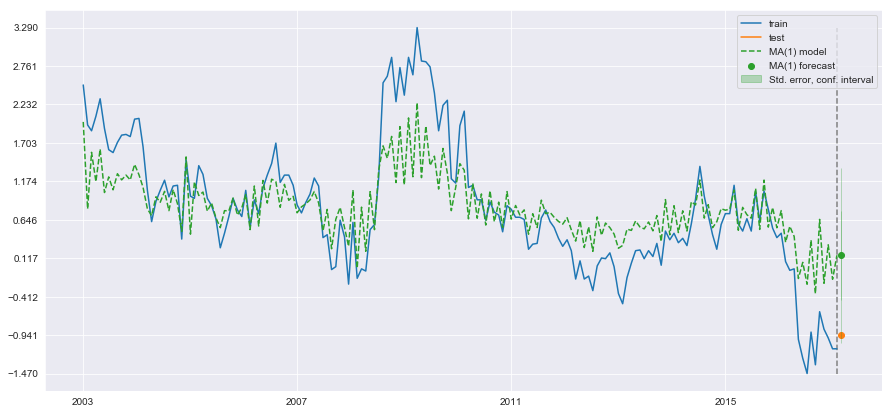

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(0, 1)   Log Likelihood                -165.311
Method:                           css   S.D. of innovations              0.616
Date:                Wed, 13 Feb 2019   AIC                            336.622
Time:                        11:35:55   BIC                            346.150
Sample:                             0   HQIC                           340.486
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8242      0.078     10.539      0.000       0.671       0.977
ma.L1.y        0.6969      0.041     16.810      0.000       0.616       0.778
                                    Roots           

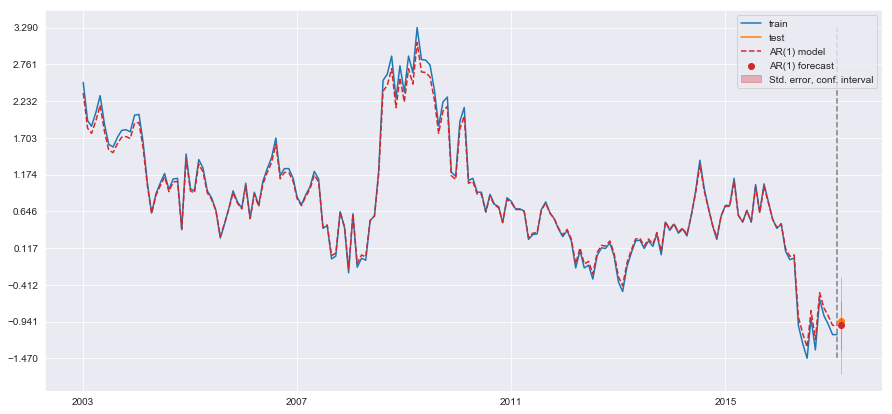

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(1, 0)   Log Likelihood                 -66.736
Method:                           css   S.D. of innovations              0.354
Date:                Wed, 13 Feb 2019   AIC                            139.472
Time:                        11:35:55   BIC                            148.983
Sample:                             1   HQIC                           143.330
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5614      0.353      1.592      0.113      -0.130       1.253
ar.L1.y        0.9212      0.030     30.746      0.000       0.863       0.980
                                    Roots           

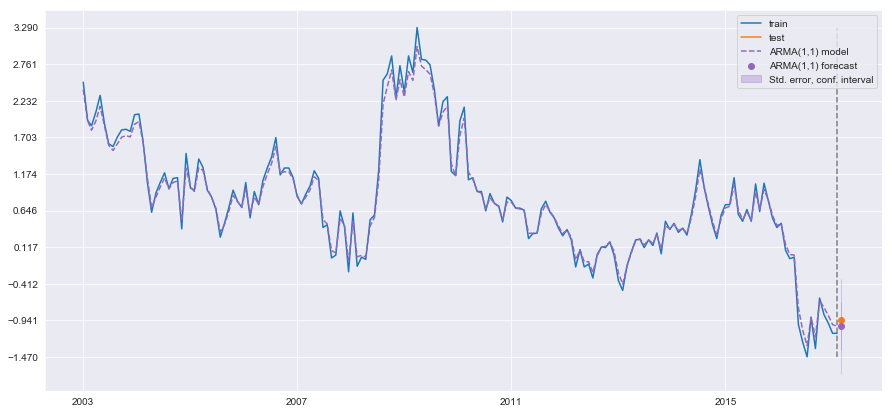

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(1, 1)   Log Likelihood                 -64.607
Method:                           css   S.D. of innovations              0.349
Date:                Wed, 13 Feb 2019   AIC                            137.214
Time:                        11:35:55   BIC                            149.896
Sample:                             1   HQIC                           142.358
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4429      0.460      0.964      0.337      -0.458       1.344
ar.L1.y        0.9470      0.027     34.718      0.000       0.894       1.000
ma.L1.y       -0.1625      0.077     -2.098      0.0

In [380]:
from statsmodels.tsa.arima_model import ARIMA
Res, Model, AIC, BIC = [], [], [], []

model_names = ['MA(1)', 'AR(1)', 'ARMA(1,1)']
orders = [(0,0,1), (1,0,0), (1,0,1)]

for i, (model_name, order) in enumerate(zip(model_names, orders)):
    show_series(train, test)
    model_color = 'C{}'.format(i+2)
    print('\n{}:'.format(model_name))
    model = ARIMA(np.array(train), order=order).fit(method='css')
    plt.plot(train.index, model.predict(1,len(train)), '--',
             color=model_color, label='{} model'.format(model_name))
    forecast, stderr, confint = model.forecast(len(test), alpha=0.05)
    plt.scatter(test.index, forecast, color=model_color,
                label='{} forecast'.format(model_name))
    plt.fill_between(test.index, confint[:,0], confint[:,1],
                     color=model_color, alpha=0.3,
                     label='Std. error, conf. interval')
    plt.fill_between(test.index, forecast-stderr, forecast+stderr,
                     color=model_color, alpha=0.3)
    plt.legend()
    plt.show()
    print(model.summary())
    Res.append(train - model.predict(1,len(train)))
    Model.append(model_name)
    AIC.append(model.aic)
    BIC.append(model.bic)

> In the implementation of ARIMA the model is fitted by the maximization of conditional sum of squares likelihood.

##### (c) Try diﬀerencing and subsequent application of MA(1), AR(1) and ARMA(1,1). Check again the processes and check the ﬁt (signiﬁcance, ACF, AIC, etc.) Decide which model is the best one.


ARIMA(0,1,1):


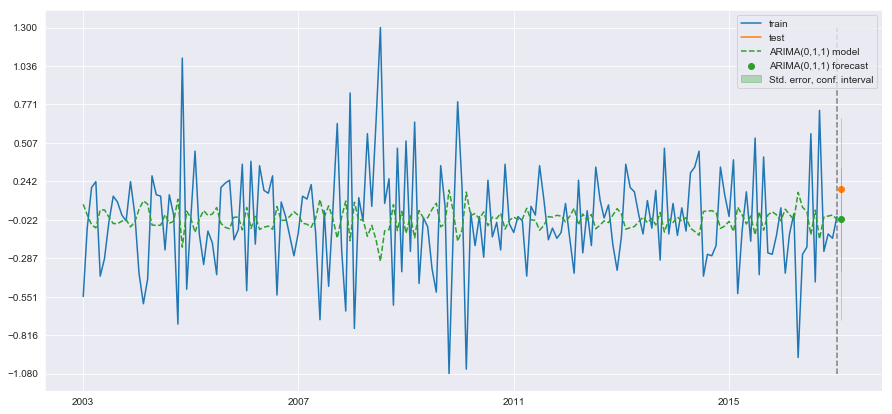

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(0, 1)   Log Likelihood                 -66.682
Method:                           css   S.D. of innovations              0.353
Date:                Wed, 13 Feb 2019   AIC                            139.363
Time:                        11:35:58   BIC                            148.875
Sample:                             0   HQIC                           143.221
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0201      0.021     -0.939      0.349      -0.062       0.022
ma.L1.y       -0.1966      0.074     -2.670      0.008      -0.341      -0.052
                                    Roots           

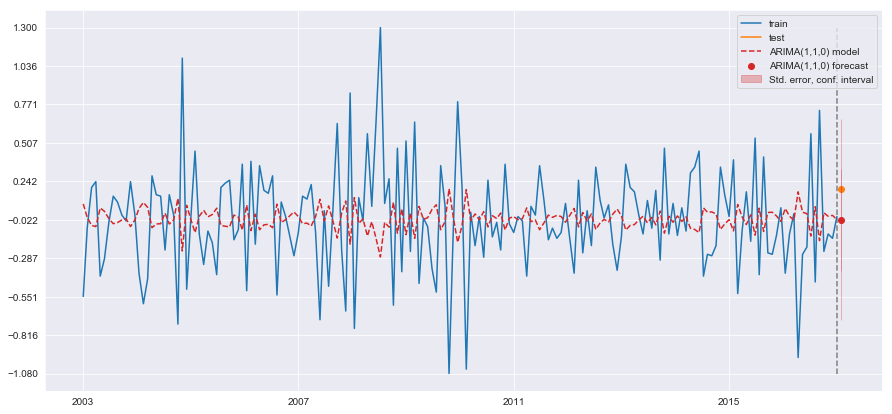

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(1, 0)   Log Likelihood                 -65.614
Method:                           css   S.D. of innovations              0.352
Date:                Wed, 13 Feb 2019   AIC                            137.229
Time:                        11:35:58   BIC                            146.723
Sample:                             1   HQIC                           141.080
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.022     -0.815      0.416      -0.062       0.025
ar.L1.y       -0.1975      0.074     -2.682      0.008      -0.342      -0.053
                                    Roots           

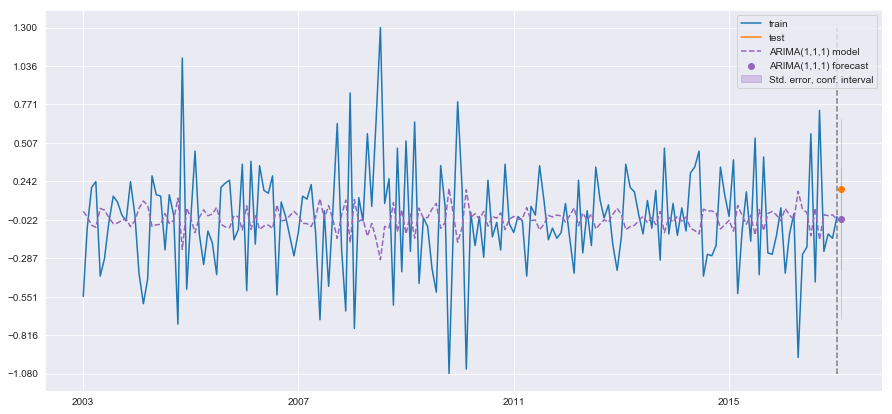

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(1, 1)   Log Likelihood                 -65.578
Method:                           css   S.D. of innovations              0.352
Date:                Wed, 13 Feb 2019   AIC                            139.157
Time:                        11:35:59   BIC                            151.816
Sample:                             1   HQIC                           144.292
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0178      0.022     -0.819      0.414      -0.061       0.025
ar.L1.y       -0.1002      0.368     -0.272      0.786      -0.821       0.621
ma.L1.y       -0.1012      0.369     -0.274      0.7

In [381]:
train_d = (train - train.shift(1))[1:]
test_d = test - train[-1]

model_names = ['ARIMA(0,1,1)', 'ARIMA(1,1,0)', 'ARIMA(1,1,1)']
orders = [(0,0,1), (1,0,0), (1,0,1)]

for i, (model_name, order) in enumerate(zip(model_names, orders)):
    show_series(train_d, test_d)
    model_color = 'C{}'.format(i+2)
    print('\n{}:'.format(model_name))
    model = ARIMA(np.array(train_d), order=order).fit(method='css')
    plt.plot(train_d.index, model.predict(1,len(train_d)), '--',
             color=model_color, label='{} model'.format(model_name))
    forecast, stderr, confint = model.forecast(len(test_d), alpha=0.05)
    plt.scatter(test_d.index, forecast, color=model_color,
                label='{} forecast'.format(model_name))
    plt.fill_between(test_d.index, confint[:,0], confint[:,1],
                     color=model_color, alpha=0.3,
                     label='Std. error, conf. interval')
    plt.fill_between(test_d.index, forecast-stderr, forecast+stderr,
                     color=model_color, alpha=0.3)
    plt.legend()
    plt.show()
    print(model.summary())
    Res.append(train_d - model.predict(1,len(train_d)))
    Model.append(model_name)
    AIC.append(model.aic)
    BIC.append(model.bic)

ACF of the residuals:

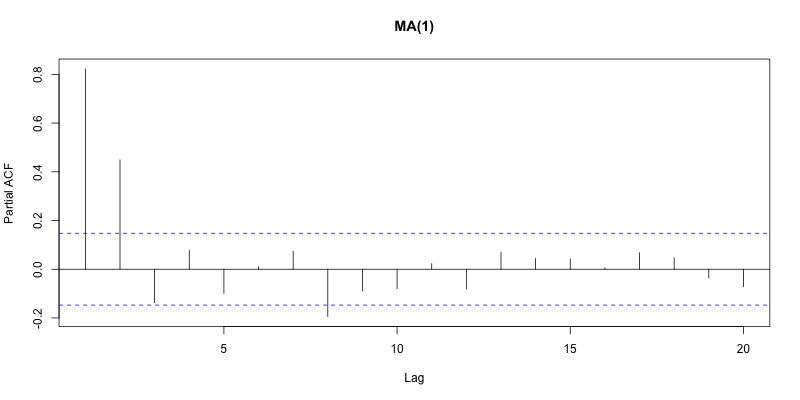

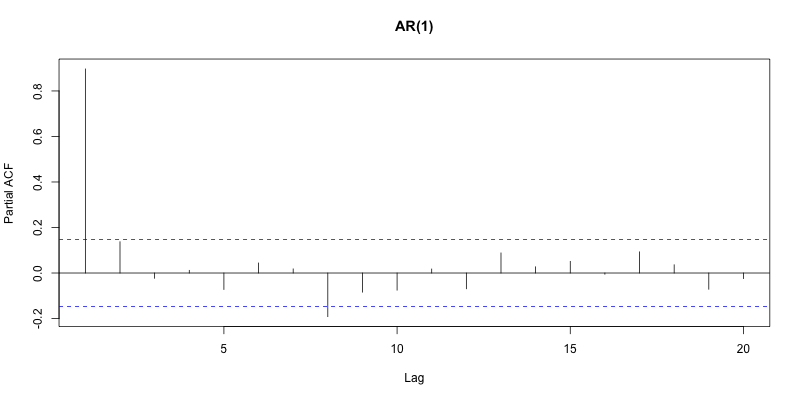

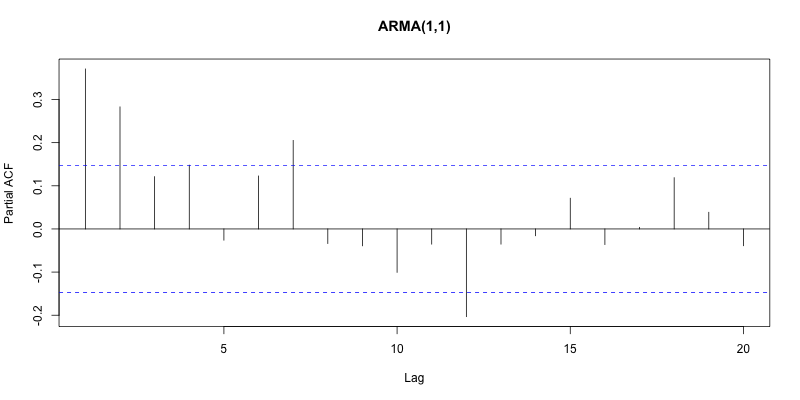

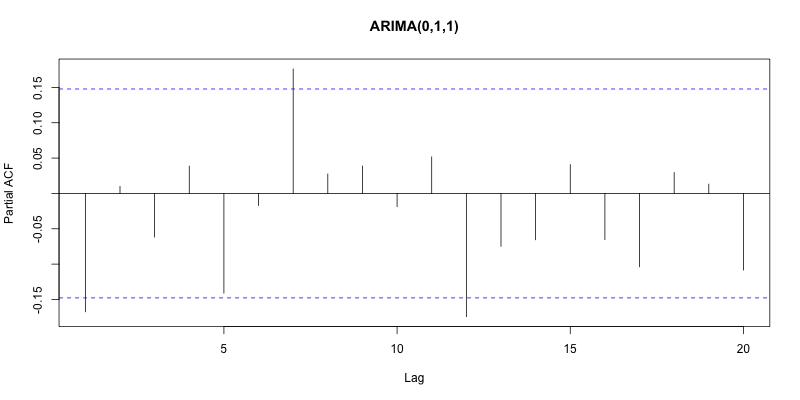

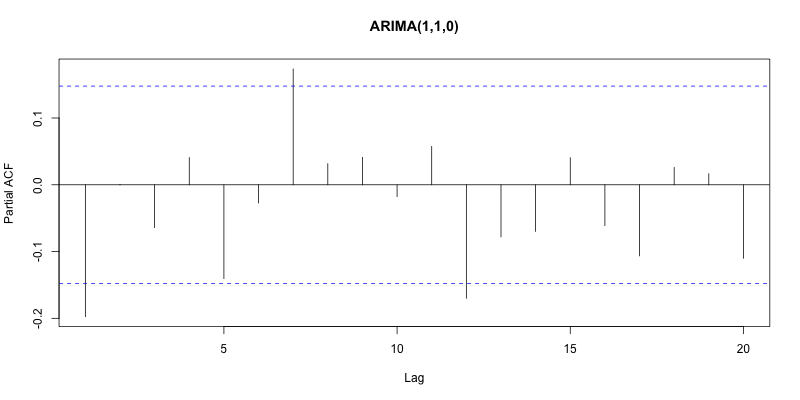

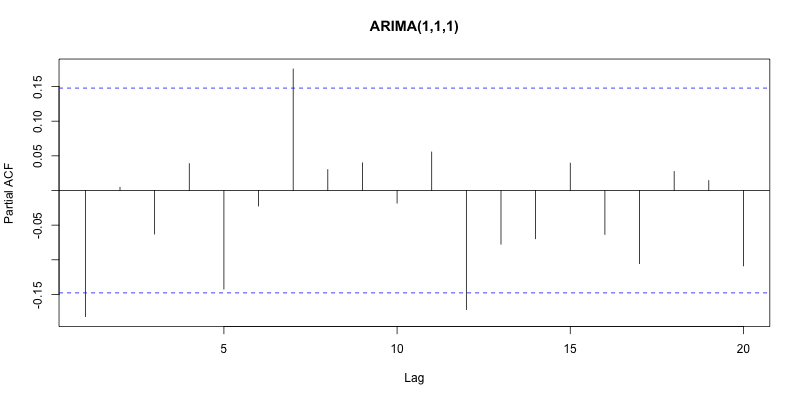

In [382]:
%%R -i Res -i Model -w 800 -h 400 -u px

cat('ACF of the residuals:')
names(Res) <- Model
for (name in names(Res))
{
AutoCorrelation <- pacf(as.numeric(Res[[name]]), lag.max=20, plot = FALSE)
plot(AutoCorrelation, main = name)
}

In [383]:
print(' Model\t\t AIC\tBIC')
aic_min = np.argmin(AIC)
bic_min = np.argmin(BIC)
for i, (m, aic, bic) in enumerate(zip(Model, AIC, BIC)):
    print('{: <15} {:.2f}{}\t{:.2f}{}'.format(m, aic, 
                                              '*' if i == aic_min else ' ',
                                              bic,
                                              '*' if i == bic_min else ' '))

 Model		 AIC	BIC
MA(1)           336.62 	346.15 
AR(1)           139.47 	148.98 
ARMA(1,1)       137.21*	149.90 
ARIMA(0,1,1)    139.36 	148.87 
ARIMA(1,1,0)    137.23 	146.72*
ARIMA(1,1,1)    139.16 	151.82 


> In terms of information criteria ARIMA(1,0,1) and ARIMA(1,1,0) are the best. By looking at the ACF one may notice that without differencing the autocorrelation at lag 1 remains high, but after differencing (autoregressive integrated moving average process) it becomes very low. Therefore ARIMA(1,1,0) is suggested as the best model.

##### (d) Try autoarima (in R) and compare the ﬁnal model with the one you found in the previous step.


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 146.49
 ARIMA(0,1,0) with drift         : 146.3579
 ARIMA(1,1,0) with drift         : 140.1561
 ARIMA(0,1,1) with drift         : 141.5407
 ARIMA(0,1,0)                    : 144.8869
 ARIMA(2,1,0) with drift         : 143.0287
 ARIMA(1,1,1) with drift         : 142.178
 ARIMA(2,1,1) with drift         : 144.7918
 ARIMA(1,1,0)                    : 138.751
 ARIMA(2,1,0)                    : 141.5415
 ARIMA(1,1,1)                    : 140.7557
 ARIMA(0,1,1)                    : 140.3444
 ARIMA(2,1,1)                    : 143.2891

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,1,0)                    : 138.0862

 Best model: ARIMA(1,1,0)                    

Series: train 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.1955
s.e.   0.0742

sigma^2 estimated as 0.1261:  log likelihood=-67.01
AIC=138.02   AICc=138.09   BIC=144.36

Training set error measures:
          

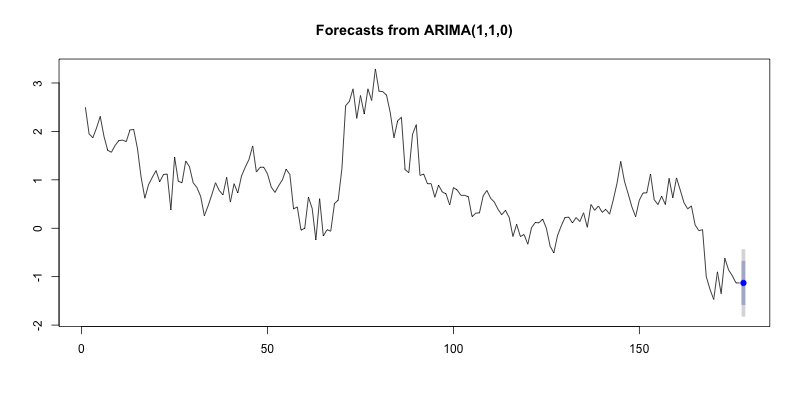

In [345]:
%%R -w 800 -h 400 -u px
library('forecast')

ARIMA <- auto.arima(train, trace=T)
plot(forecast(ARIMA, h=1))
summary(ARIMA)

> The output of `autoarima` is also ARIMA(1,1,0) $-$ the same as chosen previously.

##### (e) Compute the forecasts and forecast intervals using the ﬁnal model.


ARIMA(1,1,0)
alpha_1 = 0.5614
Forecast: -0.9968
95%-Confidence interval: (-1.6897, -0.3038)


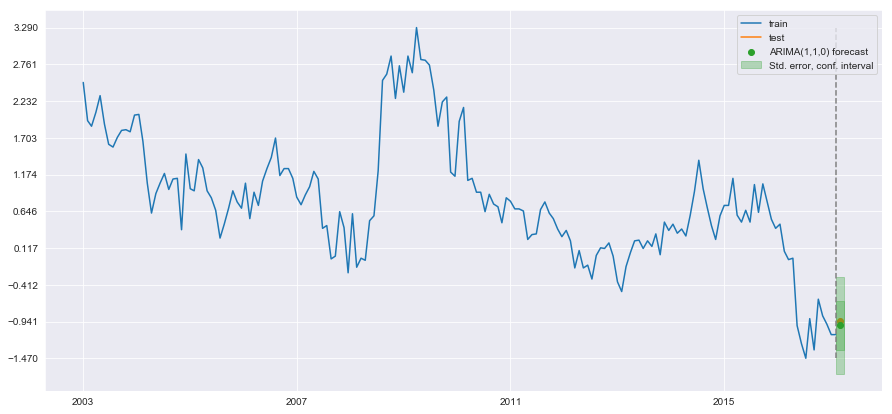

In [400]:
from statsmodels.tsa.arima_model import ARIMA
# Res, Model = [], []

model_name = model_names[-2]
order = orders[-2]

show_series(train, test)
model_color = 'C2'
model = ARIMA(np.array(train), order=order).fit(method='css')
print('\n{}'.format(model_name))
print('alpha_1 = {:.4f}'.format(model.params[0]))
print('Forecast: {:.4f}\n{}%-Confidence interval: ({:.4f}, {:.4f})'\
      .format(forecast[0], 95, *confint.squeeze()))
forecast, stderr, confint = model.forecast(len(test), alpha=0.05)
plt.scatter(test.index, forecast, color=model_color,
            label='{} forecast'.format(model_name))
plt.fill_between(interestrate.index[-3:] + pd.offsets.MonthOffset(1),
                 confint[:,0], confint[:,1],
                 color=model_color, alpha=0.3,
                 label='Std. error, conf. interval')
plt.fill_between(interestrate.index[-3:] + pd.offsets.MonthOffset(1),
                 forecast-stderr, forecast+stderr,
                 color=model_color, alpha=0.3)
plt.legend()
plt.show()

##### (f) Explain why multi-step-ahead forecasts have wider forecast intervals than onestep-ahead-forecasts.

> The variance of the multi-step-ahead forecast error depends on all the previous forecast errors variances, so the deeper we go with the forecast, the more intermediate forecast errors we get, and so the wider become the forecast intervals.

##### (g) Imagine an ACF with only the ﬁrst two correlations being signiﬁcant. Which process is suitable to model this and why?

> For the moving average process the ACF disappears for lags greater than the order of the process. So for MA(2): $~$ $\gamma_1 = \sigma_u^2(\beta_1 + \beta_1\beta_2)$, $~$$\gamma_2 = \sigma_u^2\beta_2$, $~$ the next autocovariances are zero. So in the modeling of the TS with described ACF the MA(2) should be included (if the first two correlations mean 1 & 2, otherwise if it means 0 & 1 then MA(1) may suit). The first several significant correlations may indicate a non-stationary process so one can also test the stationarity and may use integrated process.

##### (h) Imagine an ACF which consists only of positive values and quickly decays towards zero. Which process is suitable to model this and why?

> The autoregressive process AR(1) $~$ $(1-\alpha L)Y_t=u_t$ $~$ has $~$ $\rho_h = \alpha^{|h|}$ meaning that for positive small values of $\alpha$ the ACF would quickly decay towards zero. So AR(1) process is suitable for the TS with described ACF. If the falling doesn't look very consistently, AR(2) may also be considered. The parameters $\alpha_i$ of the process are likely to be small indicating quick memory lost.

##### (i) Consider an AR(1) process with parameter $\alpha_1$ . Assume we have a shock to a time series (a large error term, unexpected event) at the time point t = 10. Which impact do you expect this shock to have on the observation at time point t = 15? Provide the formula and give formal motivation.

> $Y_{10} = \alpha_1 Y_9 + u_{10} = ... = f_1(\alpha_1,u_9...u_1) + u_{10}$. We are interested in the error $u_{10}$ since it is large, it might impact the next values. So $Y_{15} = \alpha_1 Y_{14} + u_{15} = ... = \alpha_1^5 Y_{10} + \alpha_1^4 u_{11} + ... + \alpha_1 u_{14} + u_{15} = \alpha_1^5u_{10} + f_2(\alpha_1, u_{15}, ... u_{11}, u_{9}... u_{1})$. So the impact on the observation in time point $t=15$ would be the added $\alpha^5 u_{10}$.